In [5]:
from io import StringIO
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import scikitplot as skplt


In [6]:
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True)

In [7]:
data_file = "/disco-grande/datos.csv"
df = pd.read_csv(data_file)

In [8]:
# df = df[df["cc_chestpain"] !=-2147483648]

In [9]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols = [col for col in categorical_cols if col != 'disposition']

In [10]:
float_feature_mask = df.dtypes==np.float64
int64_feature_mask = df.dtypes==np.int64
int32_feature_mask = df.dtypes==np.int32
uint8_feature_mask = df.dtypes==np.uint8
numeric_cols = df.columns[uint8_feature_mask].tolist() + df.columns[float_feature_mask].tolist() + df.columns[int64_feature_mask].tolist() + df.columns[int32_feature_mask].tolist()

In [11]:
df["disposition"] =  df["disposition"].apply(lambda x: 1 if x  == 'Admit' else 0)
# ONE HOT ENCODING de categoricos
USE_ONE_HOT = False
if USE_ONE_HOT:
    df = pd.get_dummies(df, columns=categorical_cols)
else:
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [12]:
null_columns= []
for col in df.columns:
    num_nulos = df[col].isna().sum()
    if num_nulos:
        null_columns.append((col, num_nulos))

In [13]:
for col, l in null_columns:
    df[col] = df[col].fillna(0)

In [14]:
total_count = len(df)
NULL_THREESHOLD = 0.4
exclude_columns = [col for col, count in null_columns if  count / total_count > NULL_THREESHOLD  ]
feat_labels = [col  for col in df.columns if col != 'disposition' and col not in exclude_columns]

In [15]:
X = df[feat_labels]
Y = df['disposition']
random_state=42
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=random_state)
del X
del Y

In [16]:
pca = PCA(n_components=2)
pca.fit(X_train)
pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()

(array([0.99998158, 0.00001842]), 0.999999999999992)

In [17]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [22]:
n_splits = 4
def execute_model_base(model, cv = None, X_train = X_train, X_test = X_test, print_score=True, plot = True, **kwargs):
  model_kwargs = {'eval_metric': 'auc'}
  if cv:
    for (train_idx, test_idx) in cv.split(X_train,Y_train):
      if type(X_train) == np.ndarray:
        model.fit(X_train[train_idx], Y_train[train_idx] if type(Y_train) == np.ndarray else Y_train.iloc[train_idx], **kwargs)
      else:
        model.fit(X_train.iloc[train_idx], Y_train.iloc[train_idx], **kwargs)
  else:
    model.fit(X_train, Y_train, **kwargs)

  Y_pred = model.predict(X_test)
  score = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)  
  precision_ingresados = precision_score(Y_test, Y_pred, pos_label=1)
  precision_no_ingresados = precision_score(Y_test, Y_pred, pos_label=0)
  recall_ingresados = recall_score(Y_test, Y_pred, pos_label=1)
  recall_no_ingresados = recall_score(Y_test, Y_pred, pos_label=0)
  recall = recall_score(Y_test, Y_pred)
  auc = roc_auc_score(Y_test, Y_pred)
  if print_score:
    print("Score = {0:.5f}".format(score))
#     print("Precision = {0:.5f} ".format(precision))
    print("Precision Ingresados = {0:.5f} ".format(precision_ingresados))
    print("Precision No Ingresados = {0:.5f} ".format(precision_no_ingresados))
#     print("Recall = {0:.5f} ".format(recall))  
    print("Recall Ingresados = {0:.5f} ".format(recall_ingresados))
    print("Recall No Ingresados = {0:.5f} ".format(recall_no_ingresados))
    print("AUC = {0:.5f}".format(auc))
  conf_matrix = confusion_matrix(Y_pred, Y_test)
  if plot:
    sns.heatmap(conf_matrix,annot=True,fmt="d")
    plt.show()
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
    plt.plot(fpr,tpr)
    plt.show() 
def plot_score(model, X_train=X_train, X_test=X_test, print_score=True, plot = True):
  Y_pred = model.predict(X_test)
  score = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)  
  precision_ingresados = precision_score(Y_test, Y_pred, pos_label=1)
  precision_no_ingresados = precision_score(Y_test, Y_pred, pos_label=0)
  recall_ingresados = recall_score(Y_test, Y_pred, pos_label=1)
  recall_no_ingresados = recall_score(Y_test, Y_pred, pos_label=0)
  recall = recall_score(Y_test, Y_pred)
  auc = roc_auc_score(Y_test, Y_pred)
  if print_score:
    print("Score = {0:.5f} ".format(score))
    print("Precision Ingresados = {0:.5f} ".format(precision_ingresados))
    print("Precision No Ingresados = {0:.5f} ".format(precision_no_ingresados))
    print("Recall Ingresados = {0:.5f} ".format(recall_ingresados))
    print("Recall No Ingresados = {0:.5f} ".format(recall_no_ingresados))
    print("AUC = {0:.5f}".format(auc))
  conf_matrix = confusion_matrix(Y_pred, Y_test)
  if plot:
    sns.heatmap(conf_matrix,annot=True,fmt="d")
    plt.show()
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
    plt.plot(fpr,tpr)
    plt.show() 
def execute_model_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=KFold(n_splits=n_splits, random_state = random_state), *args, **kwargs)
def execute_model_stratified_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=StratifiedKFold(n_splits=n_splits, random_state = random_state), *args, **kwargs)
def execute_model_repeated_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=RepeatedKFold(n_repeats=8, n_splits=n_splits, random_state = random_state), *args, **kwargs)
def print_feature_importance_lgbm(model, X_train=X_train):
  feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
  return feature_imp.sort_values("Value", ascending =False)
def print_feature_importance_rf(model):
  sfm = SelectFromModel(model)
  sfm.fit(X_train, Y_train)
  for feature_list_index in sfm.get_support(indices=True):
      print(feat_labels[feature_list_index])

Score = 0.85665
Precision Ingresados = 0.85693 
Precision No Ingresados = 0.85658 
Recall Ingresados = 0.62235 
Recall No Ingresados = 0.95596 
AUC = 0.78916


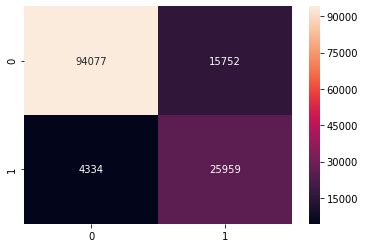

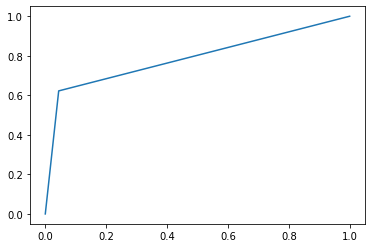

CPU times: user 3min 39s, sys: 4.05 s, total: 3min 43s
Wall time: 3min 43s


In [27]:
%%time
model_rf = RandomForestClassifier(n_estimators=40, min_samples_leaf=20)
execute_model_stratified_kfold(model_rf)

In [ ]:
r = df["disposition"].value_counts()
r[0] / len(df), r[1] / len(df)

In [ ]:
joblib.dump(model_rf, 'models/normal_rf.model')

In [ ]:
%%time
model = LGBMClassifier(objective='binary', is_unbalance=True, boosting_type='gbdt', max_depth=20, num_leaves=50)
execute_model_stratified_kfold(model, eval_metric='auc')

Score = 0.85061
Precision Ingresados = 0.71264 
Precision No Ingresados = 0.92447 
Recall Ingresados = 0.83474 
Recall No Ingresados = 0.85733 
AUC = 0.84604


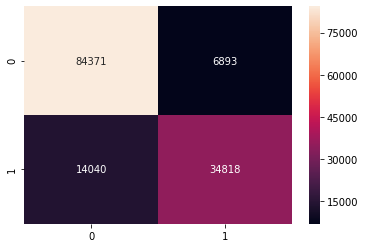

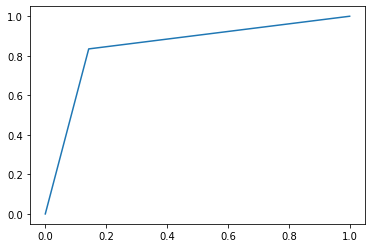

CPU times: user 9min 8s, sys: 12 s, total: 9min 20s
Wall time: 49.2 s


In [25]:
%%time
highest_corr_x = ['meds_cardiovascular',
 'esi',
 'meds_gastrointestinal',
 'meds_vitamins',
 'meds_analgesics',
 'meds_antiplateletdrugs',
 'meds_psychotherapeuticdrugs',
 'meds_diuretics',
 'meds_cardiacdrugs',
 'meds_elect/caloric/h2o',
 'meds_antiasthmatics',
 'meds_antihyperglycemics',
 'htn',
 'meds_cnsdrugs',
 'meds_unclassifieddrugproducts',
 'meds_anticoagulants',
 'meds_thyroidpreps',
 'meds_eentpreps',
 'meds_hormones',
 'meds_antiarthritics',
 'n_surgeries',
 'coronathero',
 'hyperlipidem',
 'chfnonhp',
 'n_admissions',
 'meds_antibiotics',
 'arrivalmode',
 'diabmelnoc',
 'chrkidneydisease',
 'dysrhythmia']

model = LGBMClassifier(objective='binary', is_unbalance=True, boosting_type='gbdt', num_leaves=60)
execute_model_stratified_kfold(model)

Score = 0.84988
Precision Ingresados = 0.71111 
Precision No Ingresados = 0.92443 
Recall Ingresados = 0.83486 
Recall No Ingresados = 0.85625 
AUC = 0.84555


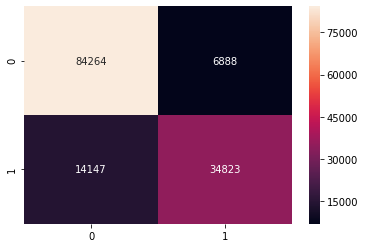

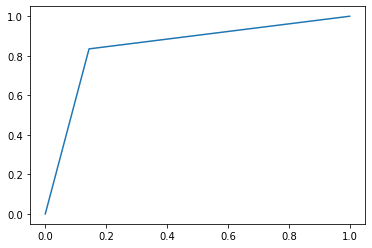

CPU times: user 2min, sys: 3.62 s, total: 2min 4s
Wall time: 13.1 s


In [24]:
%%time
highest_corr_x = ['meds_cardiovascular',
 'esi',
 'meds_gastrointestinal',
 'meds_vitamins',
 'meds_analgesics',
 'meds_antiplateletdrugs',
 'meds_psychotherapeuticdrugs',
 'meds_diuretics',
 'meds_cardiacdrugs',
 'meds_elect/caloric/h2o',
 'meds_antiasthmatics',
 'meds_antihyperglycemics',
 'htn',
 'meds_cnsdrugs',
 'meds_unclassifieddrugproducts',
 'meds_anticoagulants',
 'meds_thyroidpreps',
 'meds_eentpreps',
 'meds_hormones',
 'meds_antiarthritics',
 'n_surgeries',
 'coronathero',
 'hyperlipidem',
 'chfnonhp',
 'n_admissions',
 'meds_antibiotics',
 'arrivalmode',
 'diabmelnoc',
 'chrkidneydisease',
 'dysrhythmia']

model_2 = LGBMClassifier(objective='binary', is_unbalance=True, max_depth=20, num_leaves=50, boosting_type='gbdt')
execute_model_base(model_2)
# , X_train=X_train[highest_corr_x], X_test=X_test[highest_corr_x]


In [109]:
y_pred = model_2.predict(X_test[highest_corr_x])
precision_score(Y_test, y_pred)

0.8354428356137714

In [104]:
Y_test.value_counts()

0    98411
1    41711
Name: disposition, dtype: int64

In [103]:
df_features = print_feature_importance_lgbm(model_2, X_train=X_train[highest_corr_x])
df_features

,Value,Feature
29,498,n_admissions
28,473,esi
27,430,n_surgeries
26,357,arrivalmode
25,218,meds_psychotherapeuticdrugs
24,204,meds_cardiovascular
23,182,meds_gastrointestinal
22,175,meds_vitamins
21,172,meds_analgesics
20,170,meds_antiasthmatics


Score = 0.68288
Precision Ingresados = 0.47669 
Precision No Ingresados = 0.83047 
Recall Ingresados = 0.66807 
Recall No Ingresados = 0.68915 
AUC = 0.67861


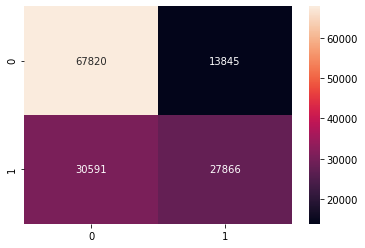

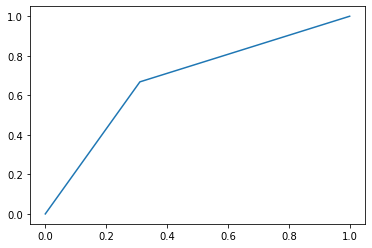

CPU times: user 11.8 s, sys: 129 ms, total: 12 s
Wall time: 2.91 s


In [28]:
%%time
model_lgbm_pca = LGBMClassifier(objective='binary', is_unbalance=True, max_depth=20, num_leaves=50)
execute_model_stratified_kfold(model_lgbm_pca, X_train=X_train_pca,X_test=X_test_pca)

In [15]:
df_features = print_feature_importance_lgbm(model)
df_features

,Value,Feature
691,218,esi
690,202,age
689,140,n_edvisits
688,136,triage_vital_hr
687,133,n_admissions
686,97,triage_vital_temp
685,96,dep_name_A
684,90,meds_cardiovascular
683,83,insurance_status_Self pay
682,79,meds_psychotherapeuticdrugs


In [ ]:
%%time
model = LGBMClassifier(objective='binary', is_unbalance=True, boosting_type='gbdt', max_depth=20, num_leaves=50)
execute_model_stratified_kfold(model)

In [38]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    #0.15,
    'learning_rate': [0.2, 0.15],
    'n_estimators': [80, 120],
    'num_leaves': [30, 40, 60],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [42], # Updated from 'seed'
#     'colsample_bytree' : [0.65, 0.66],
#     'subsample' : [0.7,0.75],
#     'reg_alpha' : [1,1.2],
#     'reg_lambda' : [1,1.2,1.4],
    }


In [3]:
??LGBMClassifier

In [39]:
mdl = LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          is_unbalance=True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])


In [40]:
%%time
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
grid.fit(X_train, Y_train)

CPU times: user 34.6 s, sys: 3.97 s, total: 38.6 s
Wall time: 5min 49s


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      is_unbalance=True, learning_rate=0.1,
                                      max_bin=512, max_depth=-1,
                                      min_child_samples=5, min_child_weight=1,
                                      min_split_gain=0.5, n_estimators=100,
                                      n_jobs=3, num_leaves=31,
                                      objective='binary', random_state=...
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      scale_pos_weight=1, silent=True,
                                      subsample=1, subsample_for_bin=200,
                                      subsample_freq=1),
             iid='warn', n_jobs=2,
      

{'boosting_type': 'gbdt', 'learning_rate': 0.15, 'n_estimators': 120, 'num_leaves': 60, 'objective': 'binary', 'random_state': 42}
0.8468686144470335
Score = 0.84914 
Precision = 0.70772 
Recall = 0.83469 
AUC = 0.84495


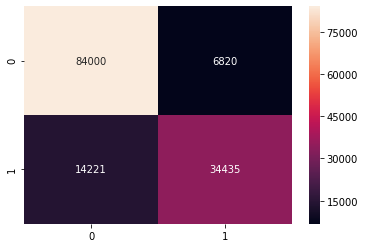

In [42]:
print(grid.best_params_)
print(grid.best_score_)
plot_score(grid.best_estimator_)

TypeError: score() missing 1 required positional argument: 'X'

In [26]:
%%time
model_xgb = XGBClassifier(max_depth=20, nrounds=30, colsample_bylevel=0.05, nthread=5,  learning_rate=0.3)
model_xgb.fit(X_train, Y_train, eval_metric='auc')
# execute_model_stratified_kfold(model_xgb)

CPU times: user 4min 31s, sys: 3.79 s, total: 4min 34s
Wall time: 1min


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.05,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nrounds=30, nthread=5, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

Score = 0.86971 
Precision Ingresados = 0.82270 
Precision No Ingresados = 0.88617 
Recall Ingresados = 0.71677 
Recall No Ingresados = 0.93453 
AUC = 0.82565


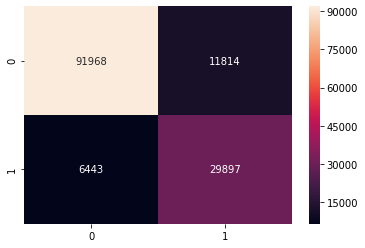

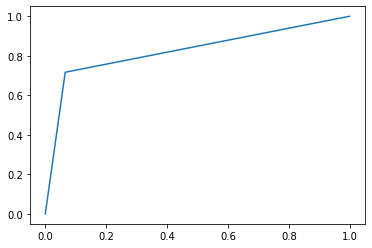

In [26]:
model_xgb = XGBClassifier(max_depth=20, nrounds=30, colsample_bylevel=0.05, nthread=5,  learning_rate=0.3)
model_xgb.fit(X_train, Y_train, eval_metric='auc')
plot_score(model_xgb)

In [112]:
%%time
highest_corr_x = ['meds_cardiovascular',
 'esi',
 'meds_gastrointestinal',
 'meds_vitamins',
 'meds_analgesics',
 'meds_antiplateletdrugs',
 'meds_psychotherapeuticdrugs',
 'meds_diuretics',
 'meds_cardiacdrugs',
 'meds_elect/caloric/h2o',
 'meds_antiasthmatics',
 'meds_antihyperglycemics',
 'htn',
 'meds_cnsdrugs',
 'meds_unclassifieddrugproducts',
 'meds_anticoagulants',
 'meds_thyroidpreps',
 'meds_eentpreps',
 'meds_hormones',
 'meds_antiarthritics',
 'n_surgeries',
 'coronathero',
 'hyperlipidem',
 'chfnonhp',
 'n_admissions',
 'meds_antibiotics',
 'arrivalmode',
 'diabmelnoc',
 'chrkidneydisease',
 'dysrhythmia']

model_xgb_2 = XGBClassifier(max_depth=20, nrounds=30, colsample_bylevel=0.05, nthread=5,  learning_rate=0.3)
model_xgb_2.fit(X_train[highest_corr_x], Y_train, eval_metric='auc')

CPU times: user 31.3 s, sys: 17.8 ms, total: 31.3 s
Wall time: 6.36 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.05,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nrounds=30, nthread=5, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

Score = 0.85348 
Precision = 0.85231 
Recall = 0.85348 
AUC = 0.78781


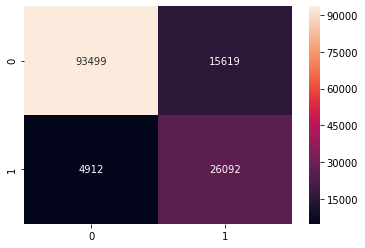

In [114]:
plot_score(model_xgb_2, X_train=X_train[highest_corr_x], X_test=X_test[highest_corr_x])

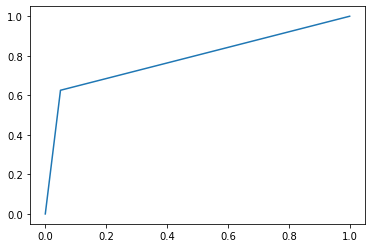

In [124]:
y_pred = model_xgb_2.predict(X_test[highest_corr_x])
# skplt.metrics.plot_roc_curve(Y_test, y_pred)
# plt.show()
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
plt.plot(fpr,tpr)
plt.show() 

In [118]:
# len(y_pred), len(Y_test)
??skplt.metrics.plot_roc_curve

In [38]:
??model_xgb.fit

In [140]:
precision_score(Y_test, y_pred, pos_label=0), precision_score(Y_test, y_pred, pos_label=1), precision_score(Y_test, y_pred)

(0.8568613794241097, 0.8415688298284092, 0.8415688298284092)

In [141]:
recall_score(Y_test, y_pred, pos_label=0), recall_score(Y_test, y_pred, pos_label=1), recall_score(Y_test, y_pred)

(0.9500868805316479, 0.6255424228620747, 0.6255424228620747)

In [19]:
??XGBClassifier

In [20]:
df_features[df_features["Feature"] == 'anemia']

,Value,Feature
467,4,anemia


In [32]:
pred_test = model_xgb.predict(X_test)


In [36]:
np.bincount(pred_test)

array([104169,  35953])

In [37]:
np.bincount(Y_test)

array([98411, 41711])